# Let's see the model actaully in use!

## We will use a ResNet50 to classify images (of Delhi, India attractions!) and upload this model into production to feel the coolness :)
Some parts of the notebook wouldn't be clear upon reading because they aren't clear to me as well. fastai teaches in a top-down fashion so just go with the flow. I'm sure things will make much more sense 2 notebooks down the road.

### Importing the required libraries

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.1.0 which is incompatible.


In [16]:
from duckduckgo_search import ddg_images # searches Bing for us!
from fastcore.all import *

def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [17]:
from fastdownload import download_url
from time import sleep
from fastai.vision.all import *

searches = 'akshardham', 'lotus temple', 'qutub minar', 'taj mahal', 'jama masjid', 'red fort','humayuns tomb' ,'india gate'
path = Path('delhi_attractions')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'Delhi {o} exterior, day photos'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'Delhi {o} exterior, night photos'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Delhi akshardham exterior, day photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Searching for 'Delhi akshardham exterior, night photos'
Searching for 'Delhi lotus temple exterior, day photos'
Searching for 'Delhi lotus temple exterior, night photos'
Searching for 'Delhi qutub minar exterior, day photos'
Searching for 'Delhi qutub minar exterior, night photos'
Searching for 'Delhi taj mahal exterior, day photos'
Searching for 'Delhi taj mahal exterior, night photos'
Searching for 'Delhi jama masjid exterior, day photos'
Searching for 'Delhi jama masjid exterior, night photos'
Searching for 'Delhi red fort exterior, day photos'
Searching for 'Delhi red fort exterior, night photos'
Searching for 'Delhi humayuns tomb exterior, day photos'
Searching for 'Delhi humayuns tomb exterior, night photos'
Searching for 'Delhi india gate exterior, day photos'
Searching for 'Delhi india gate exterior, night photos'


### Let's remove the photos which were downloaded incorrectly by ddg

In [18]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

33

### We need a place to store all this collected data, thus we use DataBlock

In [19]:
# DataBlock is how we assemble and tell the fastai library about our data, like 'pd' for tabular data
attractions = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # 20% val set; seed=42 means we'll get the same validation set
    # as in the previous run.
    get_y=parent_label,
    item_tfms=[Resize(192)]
)

### Show me some images!

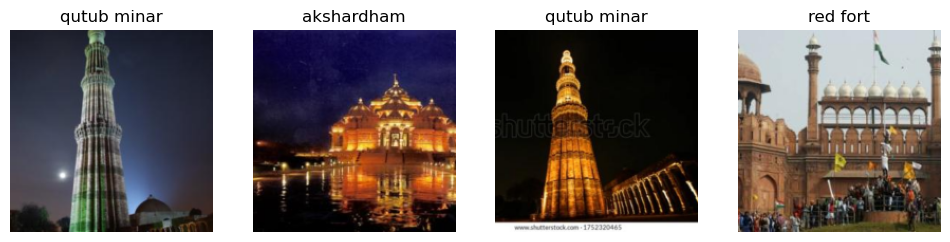

In [20]:
dls = attractions.dataloaders(path) # could've simply stored DataBlock in dls but I want to see different image
# resize techniques, so stored in some other variable to avoid chaning in-place
dls.show_batch(max_n=4, nrows=1) # 'crop' is default, it means removing the outer part of the image to get the desired size

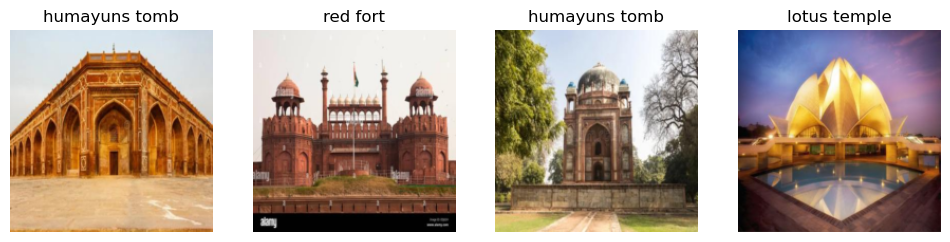

In [21]:
attractions = attractions.new(item_tfms=[Resize(192, method='squish')]) # 'squish' squeezes the picture, 
# so things inside look thinner but we get all the parts of the image without removing anything.
dls = attractions.dataloaders(path)
dls.show_batch(max_n=4, nrows=1)

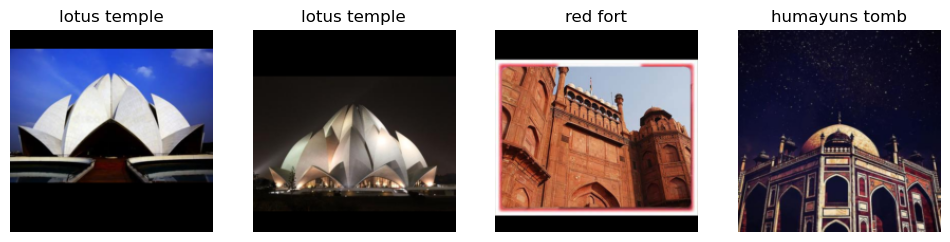

In [22]:
attractions = attractions.new(item_tfms=[Resize(192, method='pad', pad_mode='zeros')])
dls = attractions.dataloaders(path, bs=32)
dls.show_batch(max_n=4, nrows=1)

### Training the model

In [23]:
attractions = attractions.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls=attractions.dataloaders(path)

In [24]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(10) # since we are using a pre-trained model (resnet), we just want to update its last layers.
# .fine_tune trains the model to make more changes in the 'head' part of the NN, in an optimum way (I don't know how). 
# 4 is no. of epochs.
# This practice of using pre-trained models is called transfer learning.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.076686,0.160176,0.036474,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.204923,0.133517,0.033435,00:10
1,0.154964,0.128325,0.024316,00:10
2,0.127876,0.097975,0.018237,00:10
3,0.099202,0.099378,0.018237,00:10
4,0.083773,0.126441,0.027356,00:10
5,0.064870,0.091131,0.021277,00:11
6,0.054155,0.126947,0.015198,00:10
7,0.043462,0.098340,0.015198,00:10
8,0.034056,0.092565,0.015198,00:10
9,0.027290,0.094250,0.015198,00:10


Neat!

### Understanding the output
As taught in the lecture, it is better to train the model first and understand the output, this will give us some insights on what needs to be cleaned. And then go to clean the data.

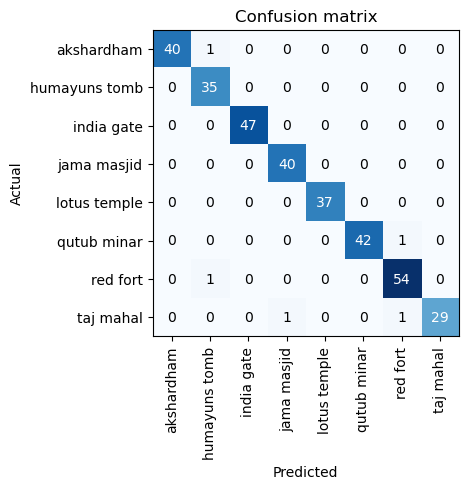

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

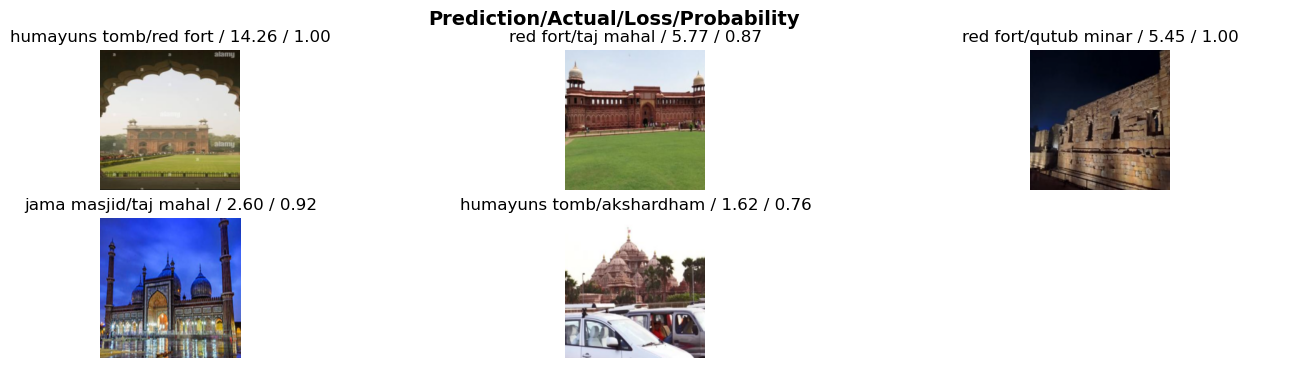

In [26]:
interp.plot_top_losses(5, nrows=2, figsize=(17,4)) # Interpreting loss here, a loss will be bad (high) if we predict  
# something wrongly and we are very confident about that prediction.

### Let's clean the images
The above output tells us clearly that there is a data labelling problem in some images. Ex: The [1, 2] image is actually a red fort but it is wrongly labelled as taj mahal. The numbers tells us something like; the first image probability of 1.00 tells us that the model is 100% sure that it is a humayuns tomb, although it isn't, thus the loss is shot up to 14.26, which is pretty bad :(

In [28]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [29]:
# this actually makes the changes we made through the GUI
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [30]:
learn.export('DelhiAtrr.pkl')